In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

import tensorflow as tf
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_MNIST'
altName = 'tf_cnn'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
#tf.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)  #setting random state to numpy
tf.random.set_seed(RANDOM_STATE)  #setting random state to tensorflow

EPOCHS = 100 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
#TEST_SIZE = 0.2
PATIENCE = 20
LR_PATIENCE = 10  #normally kept half of patience
LR_FACTOR = 0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (9, 9),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

In [4]:
trainFilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
testFilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(trainFilepath)
test_df = pd.read_csv(testFilepath)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class_labels = {0 : 'T-shirt/top',
                1  : 'Trouser',
                2  : 'Pullover',
                3 : 'Dress',
                4 : 'Coat',
                5 : 'Sandal',
                6 : 'Shirt',
                7 : 'Sneaker',
                8 : 'Bag',
                9 : 'Ankle boot'}

In [6]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

<Axes: xlabel='label'>

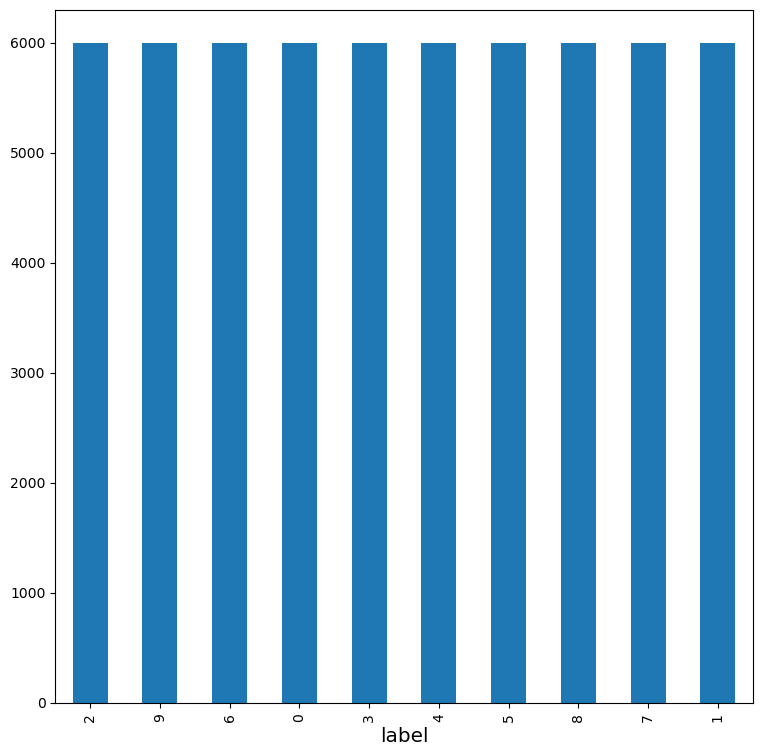

In [7]:
train_df['label'].value_counts().plot(kind='bar')

## Prepare data

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [10]:
def split_feature_label(row):
    feature = tf.reshape(row[1:],[28,28,1])
    label = row[0]
    return feature, label

In [11]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)

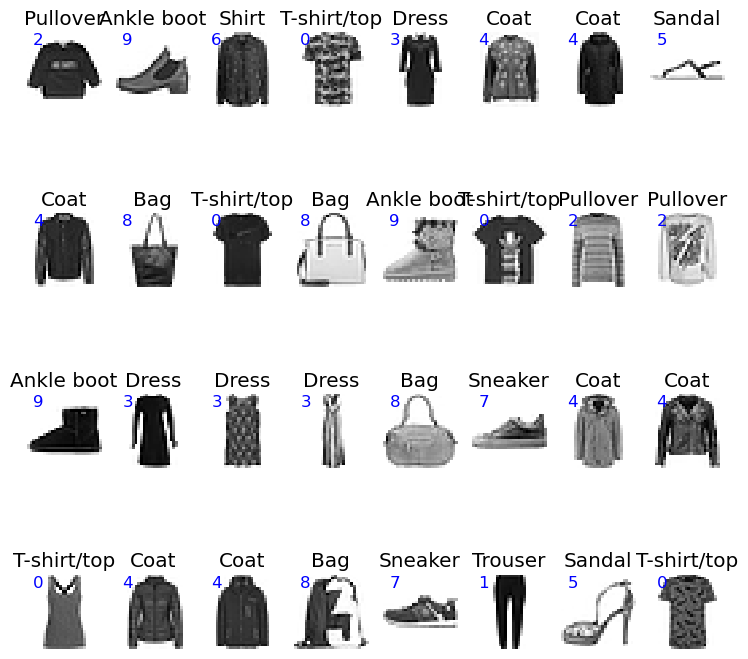

In [12]:
# Sample data plot

for images, labels in train_ds.take(1):

    for i in range(BATCH_SIZE):

        plt.subplot(4, int(BATCH_SIZE//4), i+1)
    
        plt.imshow(images[i].numpy().astype('uint16'),
                   cmap=plt.cm.binary, 
                   interpolation='nearest')   # show image on the axis
    
        plt.title(class_labels[labels[i].numpy()])     # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image

        plt.axis('off')
    
plt.show()

In [13]:
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

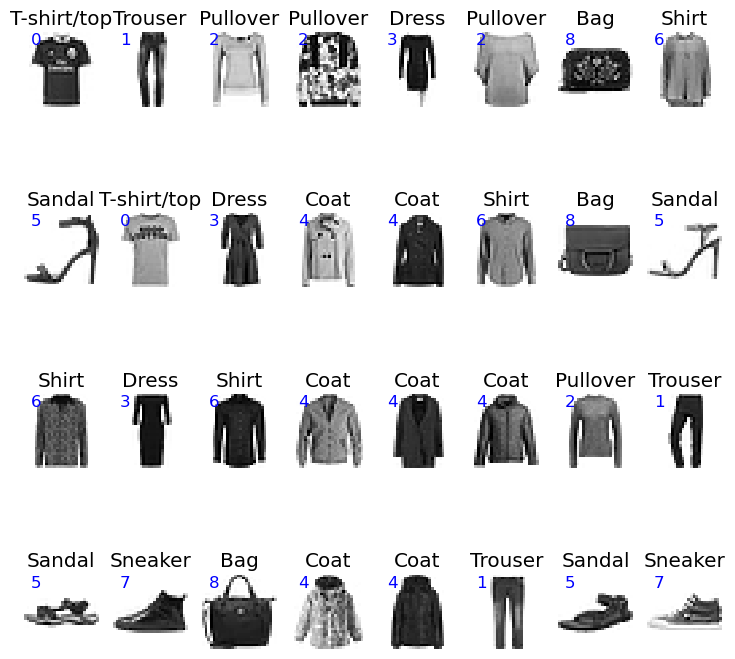

In [14]:
# Sample data plot

for images, labels in test_ds.take(1):

    for i in range(BATCH_SIZE):

        plt.subplot(4, int(BATCH_SIZE//4), i+1)
    
        plt.imshow(images[i].numpy().astype('uint16'),
                   cmap=plt.cm.binary, 
                   interpolation='nearest')   # show image on the axis
    
        plt.title(class_labels[labels[i].numpy()])     # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image

        plt.axis('off')
    
plt.show()

In [15]:
#optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
norm_layer = tf.keras.layers.Rescaling(1./225.)  #Rescaling layer

images, labels = next(iter(train_ds))            #one batch

img = images[0].numpy()                          #converting to numpy 

print(img.max(),img.min())                       #looking at min max value

#---------------------------------------------------------------------------------

norm_ds = train_ds.map(lambda x,y : (norm_layer(x), y))

images, labels = next(iter(norm_ds))            #one batch

img = images[0].numpy()                          #converting to numpy 

print(img.max(),img.min())      


255 0
1.1333333 0.0


## Convolution layer

In [17]:
input_shape = (1,6,6,1) #batch x h x w x c
X = tf.random.normal(input_shape)

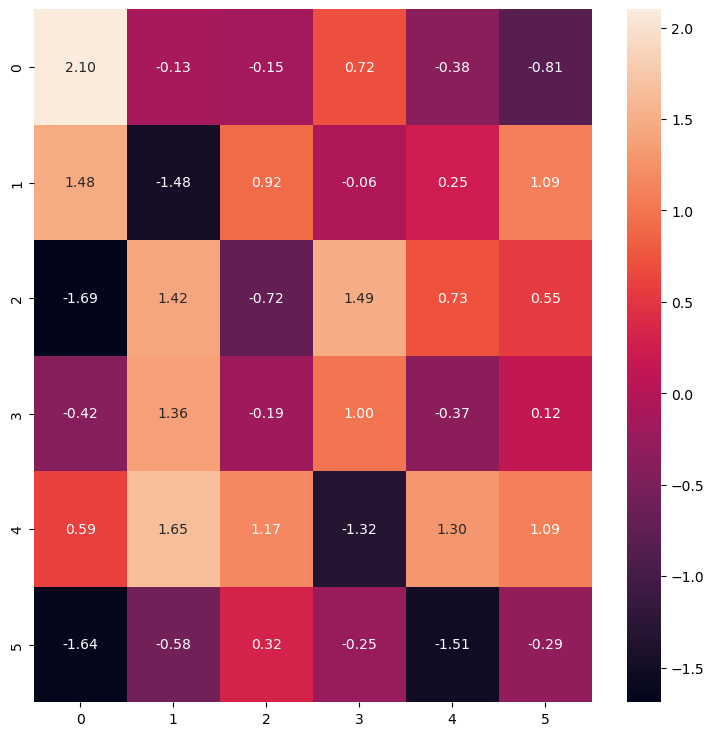

In [18]:
sns.heatmap(X. numpy()[0, :, :, 0], annot=True, fmt='.2f');

In [19]:
y = tf.keras.layers.Conv2D(1, 3, 
                           kernel_initializer = tf.constant_initializer(1.), 
                           use_bias = False, activation='relu',
                           input_shape = input_shape[1:])(X)
y.shape

TensorShape([1, 4, 4, 1])

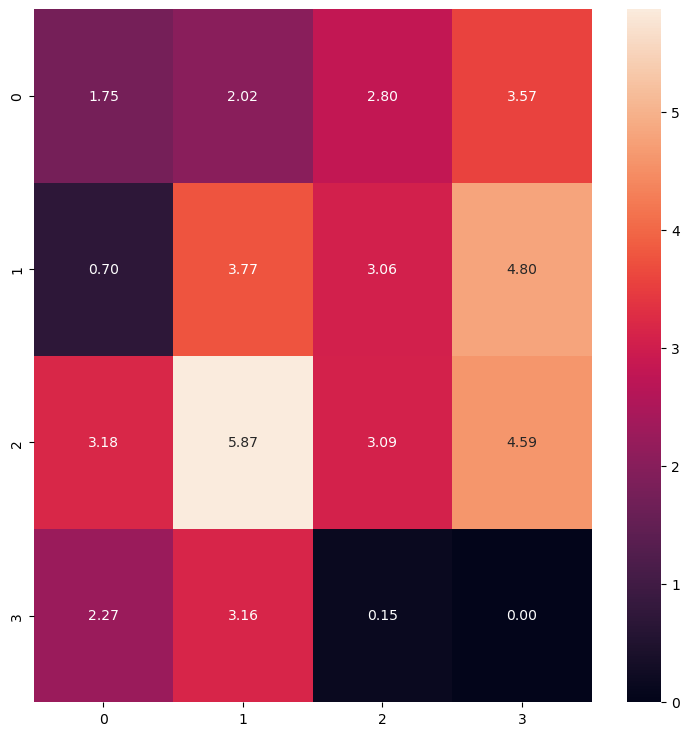

In [20]:
sns.heatmap(y.numpy()[0, :, :, 0], annot=True, fmt='.2f');

## Max pool layer

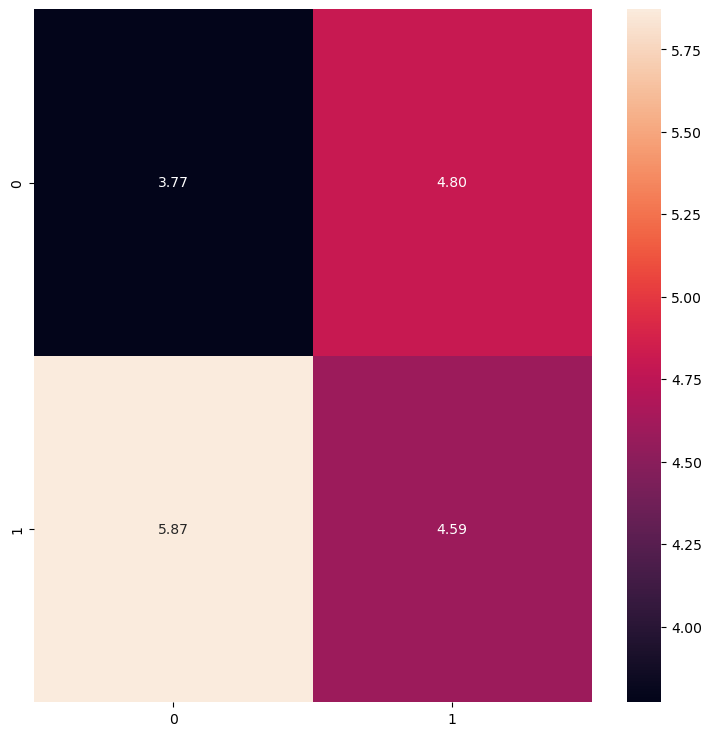

In [21]:
max_pool_layer = tf.keras.layers.MaxPool2D(pool_size = (2,2),
                                   strides = (2,2),
                                   padding = 'valid')
z = max_pool_layer(y)
sns.heatmap(z.numpy()[0, :, :, 0], annot=True, fmt='.2f');

In [22]:
reg_lambda = 0.005

knl_reg = tf.keras.regularizers.L2(reg_lambda)

model = tf.keras.Sequential()

#Preprocessing
model.add(tf.keras.layers.Rescaling(1./255.))

#-------------------------------------------------------------------------------
#Set1
model.add(tf.keras.layers.Conv2D( 32, 3, 
    padding='same',
    activation='relu',
    kernel_regularizer = knl_reg,                             
    input_shape = (28, 28, 1)))           #28 x 28 x 32

#Max pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 14 X 14 X 32



#-------------------------------------------------------------------------------
#Set2
model.add(tf.keras.layers.Conv2D( 64, 3, 
    activation='relu',
    kernel_regularizer = knl_reg))           #12 x 12 x 64

#Max pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 6 X 6 X 64



#-------------------------------------------------------------------------------
#Set3
model.add(tf.keras.layers.Conv2D( 128, 3, 
    activation='relu',
    kernel_regularizer = knl_reg))           #4 x 4 x 128



## Head

In [23]:
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = knl_reg))

model.add(tf.keras.layers.Dense(10))

In [24]:
model.compile(optimizer='adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
checkpoint_path = os.path.join(modelDir, subDir, 'CNN')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True)

es_checkpoint = tf.keras.callbacks.EarlyStopping( #early stopping call back, after some time 
    monitor='val_loss',                           #if there is no change in loss then assume it is only your good weights
    patience=PATIENCE,
    mode='auto',
    restore_best_weights=True
)

lr_checkpoint = tf.keras.callbacks.ReduceLROnPlateau(   #learning rate call back used for decreasing learning rate, when loss is not improving
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.00001
)

In [26]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks = [model_checkpoint, es_checkpoint, lr_checkpoint],
                    verbose=2)

Epoch 1/100



Epoch 1: val_loss improved from inf to 0.63549, saving model to ../models\fashion_MNIST\CNN
1875/1875 - 21s - loss: 0.8113 - accuracy: 0.7980 - val_loss: 0.6355 - val_accuracy: 0.8460 - lr: 0.0010 - 21s/epoch - 11ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.63549 to 0.57720, saving model to ../models\fashion_MNIST\CNN
1875/1875 - 19s - loss: 0.6137 - accuracy: 0.8413 - val_loss: 0.5772 - val_accuracy: 0.8543 - lr: 0.0010 - 19s/epoch - 10ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.57720 to 0.54618, saving model to ../models\fashion_MNIST\CNN
1875/1875 - 18s - loss: 0.5724 - accuracy: 0.8526 - val_loss: 0.5462 - val_accuracy: 0.8573 - lr: 0.0010 - 18s/epoch - 10ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.54618 to 0.52395, saving model to ../models\fashion_MNIST\CNN
1875/1875 - 19s - loss: 0.5471 - accuracy: 0.8584 - val_loss: 0.5240 - val_accuracy: 0.8624 - lr: 0.0010 - 19s/epoch - 10ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.523

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         7

In [28]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.811321,0.798017,0.635487,0.8460,0.001
1,0.613744,0.841250,0.577195,0.8543,0.001
2,0.572426,0.852617,0.546185,0.8573,0.001
3,0.547052,0.858417,0.523954,0.8624,0.001
4,0.530606,0.862383,0.518056,0.8634,0.001


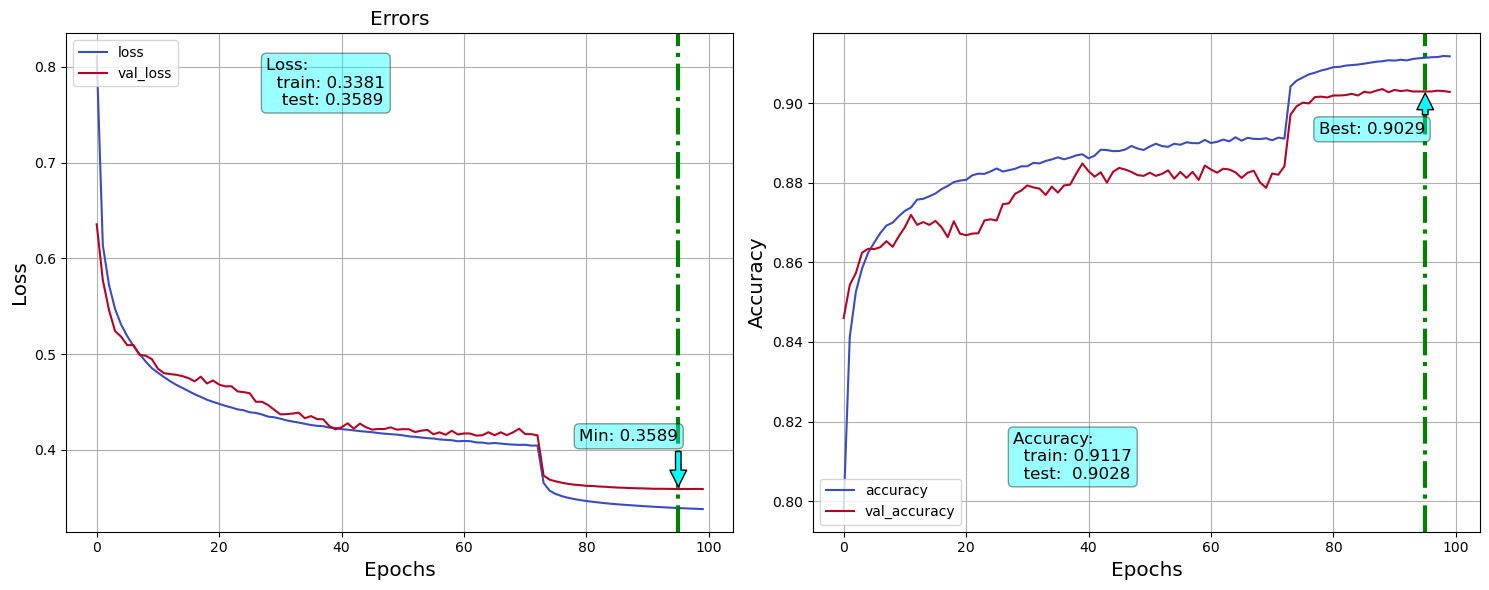

In [29]:
fn_plot_tf_hist(loss_df)